# Generate a notch list

This notebook is meant as a tutorial on how to create a `StochNotchList` object from the `notch` module within `pygwb`. More information about the `notch` module can be found on the documentation page [here](https://a-renzini.github.io/pygwb/api/pygwb.notch.html).

We start by importing some packages needed for the execution of the tutorial:

In [1]:
import numpy as np 
from pygwb import notch

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

*Note: make sure to run this notebook within an environment that has all the above packages installed.*

In this tutorial we will create a `StochNotchList` object that can be used in pygwb to apply a notch mask to the analysis. The `notch` module assumes one already knows which lines should be notched, and is not a tool to identify lines to be notched. If this is not the case, one should first use other tools to understand which frequencies should be notched.

In this tutorial, we will consider the three detectors H1, L1, and V1. We will create three different notch lists, one for each baseline, i.e., HL, HV and LV. We assume the following lines are present:

- H1: calibration line from 16.6Hz to 17.6Hz

- L1: calibration line from 434.4 to 435.4

- V1: calibration line from 16.9Hz to 17.1Hz

- H1, L1: powerlines at 60Hz and harmonics

- V1: powerlines at 50Hz and harmonics

- all baselines : pulsar injections (see data file in input) 

- HV-baseline: a comb of lines at 1Hz and multiples (up to 500Hz), width of 0.01 Hz.


*Note: Only lines up to 2024Hz will be considered.*

*Disclaimer: The examples used here are for illustrative purpose and shouldn't be considered as a realistic scenario, although realistic examples are given.*

## Background information about the different lines that should be notched

**Calibration lines** - At specific frequencies, lines are inserted by moving the mirrors to use this information to calibrate the data. Calibration lines are specififc to each detector and should be notched in the baselines containing those detectors.

**Power lines** - Typically there are strong lines present at the frequency of the power mains. Power mains lines are at 60Hz and harmonics for the US power grid (LIGO) and at 50Hz and harmonics for the Italian power grid (Virgo). They should be notched in the baselines containing those detectors.

**Violin modes** - Violin modes are the thermally excited resonances of the mirror suspensions. Violin modes are detector specific and the violin modes of each detector should be notched in the baselines containing those detectors.

**Pulsar injections** - These are narrowband signals injected to validate pipelines searching for continous waves from e.g. pulsars. The injections are the same in the different detectors and should be notched.

**Environmental/instrumental lines and baseline specific lines** - Wheareas all the previous classes of lines are by default known, there are many lines caused by the local environment and/or instruments, such as a 1 Hz comb due to GPS synchronistation. Environmental/instrumental lines are typically only notched in stochastic searches when they show up coherently in a time-shifted or non time-shifted analysis, and their source is identified to be of environmental/instrumental origin. In that scenario, the line is notched for the baseline that is affected. If all (un)known experimental/instrumental for each detector were to be subtracted, this would lead to a significant loss of frequencies to analyse, even if they didn't affect the search for a gravitational-wave background since they aren't coherent between the different detectors.

## Creation of an example notch list

We now create three separate notch lists using the `StochNotchList` method from the `notch` module. As a helper function to create the notches for the calibration lines, we define the `calibration_lines` in this notebook:

In [3]:
def calibration_lines(det):
    notches = notch.StochNotchList([])
    if det == "H1":
        notches.append(notch.StochNotch(16.6, 17.6, "H1 calibration line"))
    if det == "L1":
        notches.append(notch.StochNotch(434.4, 435.4, "L1 calibration line"))
    if det == "V1":
        notches.append(notch.StochNotch(16.9, 17.1, "V1 calibration line"))
    return notches

In this tutorial, we consider the various notches as mentioned at the start of the tutorial (note that this is just purely for illustrative purposes): 

In [4]:
noise_power_lines_60 = notch.power_lines(nharmonics=np.ceil(2024./60.))
noise_power_lines_50 = notch.power_lines(fundamental=50, nharmonics=np.ceil(2024./50.))
noise_calibration_lines_H1 = calibration_lines(det="H1")
noise_calibration_lines_L1 = calibration_lines(det="L1")
noise_calibration_lines_V1 = calibration_lines(det="V1")
noise_pulsar_injections = notch.pulsar_injections("input/Toy_example_pulsars.dat", t_start=1238112018, t_end=1269363618)

These notches can now be added to a `StochNotchList`, where such a list is created for each of the baselines (HL,HV, and LV) to account for the correct notches (including notches specific to a single detector of the baseline): 

In [5]:
noise_lines_HL = notch.StochNotchList([])
noise_lines_HL.extend(noise_power_lines_60)
noise_lines_HL.extend(noise_calibration_lines_H1)
noise_lines_HL.extend(noise_calibration_lines_L1)
noise_lines_HL.extend(noise_pulsar_injections)

noise_lines_HV = notch.StochNotchList([])
noise_lines_HV.extend(noise_power_lines_60)
noise_lines_HV.extend(noise_power_lines_50)
noise_lines_HV.extend(noise_calibration_lines_H1)
noise_lines_HV.extend(noise_calibration_lines_V1)
noise_lines_HV.extend(noise_pulsar_injections)
noise_lines_HV.extend(notch.comb(1, 1, 500, 0.01))

noise_lines_LV = notch.StochNotchList([])
noise_lines_LV.extend(noise_power_lines_60)
noise_lines_LV.extend(noise_power_lines_50)
noise_lines_LV.extend(noise_calibration_lines_L1)
noise_lines_LV.extend(noise_calibration_lines_V1)
noise_lines_LV.extend(noise_pulsar_injections)

For future use, we save the notch lists to file, using the dedicated `save_to_txt` method:

In [6]:
noise_lines_HL.save_to_txt('output/Toy_example_HL_notchlist.txt')
noise_lines_HV.save_to_txt('output/Toy_example_HV_notchlist.txt')
noise_lines_LV.save_to_txt('output/Toy_example_LV_notchlist.txt')

## Applying a notch list

For the remainder of the tutorial, we focus on the HL baseline and illustrate how a notch list can be applied to a data set. However, the notch list can be applied to different baselines in an analogous way. Furthermore, although we can just use the notchlist defined earlier in this notebook, we will read in the notch list from its saved txt file to demonstrate this functionality (using the `load_from_file` method).

In [7]:
HL_notch_list = notch.StochNotchList([])
HL_notch_list = HL_notch_list.load_from_file('output/Toy_example_HL_notchlist.txt')

For the sake of the tutorial, we will use the aLIGO design sensitivity curve as our data, which can be downloaded from [here](https://dcc.ligo.org/LIGO-T1800044/public). For simplicity, this file is also included in the 'input' directory (v5 of the file, to be precise). We now read in this data set:

In [8]:
frequencies_tmp ,data_tmp = np.loadtxt('input/aLIGOdesign.txt',usecols=(0,1),unpack=True)

We choose to only perfrom our analysis in the frequency region from 20Hz to 1012Hz with a 1/32 Hz (0.03125 Hz) resolution. We therefore perform an interpolation of the data that was just read in, to have the correct frequencies.

*Note: we strongly advice to always use powers of two as bin width, otherwise your frequencies might not be represented exactely do to non-exact representation in binary.*

In [10]:
frequencies = np.arange(20, 1012, 0.03125)
data = np.interp(frequencies, frequencies_tmp, data_tmp)[:np.size(frequencies)]

To obtain the frequency mask from the notch list, we use the `get_notch_mask` method, and apply it to the data, simply with a multiplication:

In [11]:
HL_notch_mask = HL_notch_list.get_notch_mask(frequencies)
data_notched = data * HL_notch_mask

We now plot the data before and after applying the notches:

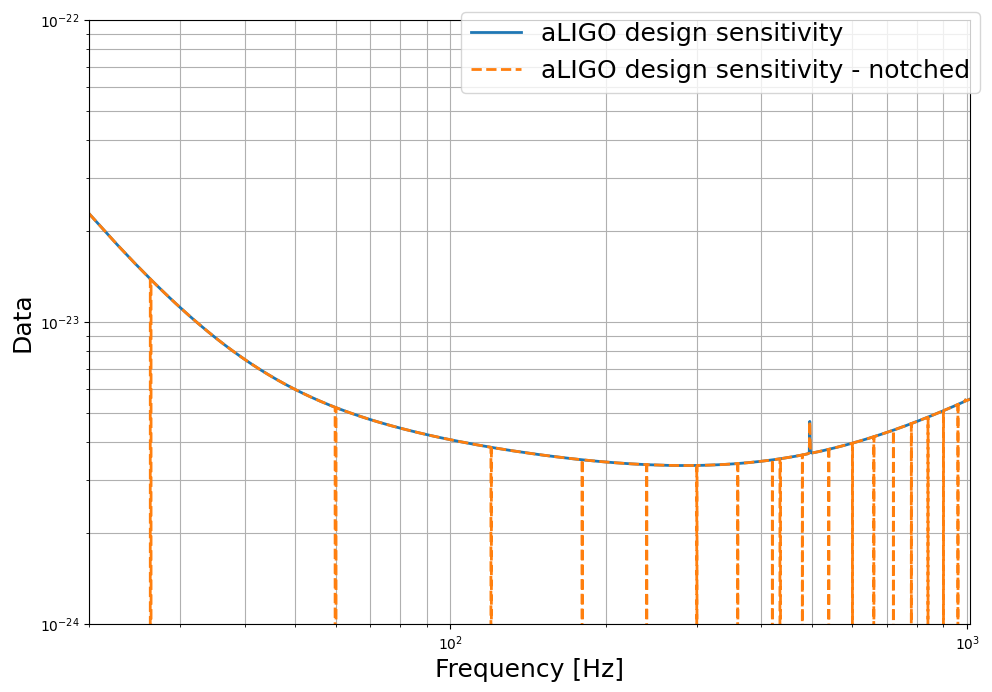

In [15]:
fig, axs = plt.subplots(1,1,figsize=(10,7))
axs.plot(frequencies,data,label='aLIGO design sensitivity', linewidth = 2)
axs.plot(frequencies,data_notched,label='aLIGO design sensitivity - notched', linewidth = 2, ls='dashed')
plt.ylabel('Data',fontsize=18)
plt.xlabel('Frequency [Hz]',fontsize=18) 
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim(20,1012)
axs.set_ylim(1e-24,1e-22)
fig.legend(fontsize=18)
plt.grid(True, which="both", ls="-")
fig.tight_layout()

The above plot shows that the frequenies contained in the notch list have been "zeroed" out, i.e. notched.

As a final step, one could decide to save the actual frequency mask (note not the notch list) to file by using the `save_notch_mask` method:

In [17]:
HL_notch_list.save_notch_mask(frequencies,'./output/notch_mask_Toy_example_HL.txt')